# 0. Import necessary files, libraries

In [2]:
import numpy as np
import torch
from config import keywords
import ai8x
import random
import matplotlib.pyplot as plt
import itertools
import torch.nn as nn

## 0.1 Define useful functions that I change frequently

In [3]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right", va="top")
    plt.yticks(tick_marks, classes)

    plt.xlim(-0.5, len(classes)-0.5) # Add this line to remove white area
    plt.ylim(len(classes)-0.5, -0.5) # Add this line to remove white area

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
class MaskedXentMarginLoss:    #损失函数
    def __init__(self, zero_weight=1.0, one_weight=1., margin=0.7, eps=1e-7, **kwargs):
        self.margin = margin
        self.zero_weight = zero_weight
        self.one_weight = one_weight
        self.eps = eps

    def __call__(self, pred, labels):
        pred = torch.clamp(pred, min=self.eps, max=1-self.eps)
        loss_mat = -self.one_weight * labels * torch.log(pred) * (pred <= self.margin).float()
        loss_mat -= self.zero_weight * (1 - labels) * torch.log(1-pred) * (pred >= 1 - self.margin).float()
        mask = ((labels == 0) + (labels == 1))
        loss = loss_mat[mask].sum()
        return loss

In [5]:
def get_batch_no_bck(data, targets, batch_size=32):

    K = len(set(np.squeeze(targets)))
    data_dim = data.shape[1]
    targets = np.asarray(targets)
    anchor = np.zeros((batch_size, data_dim))
    friend = np.zeros((batch_size, data_dim))
    foe = np.zeros((batch_size, data_dim))

    for k in range(batch_size):
        c1, c2 = random.sample(range(K), 2)
        friend_clas_indices = np.where(targets == c1)[0]
        foe_clas_indices = np.where(targets == c2)[0]

        anchor_inx, friend_inx = random.sample(list(friend_clas_indices), 2)
        foe_inx = random.sample(list(foe_clas_indices),1) [0]
        anchor[k, :] = data[anchor_inx]
        friend[k,  :] = data[friend_inx]
        foe[k, :] = data[foe_inx]

    friend_label = np.ones(batch_size)
    foe_label = np.zeros(batch_size)

    batch_1 = torch.from_numpy(np.concatenate((anchor, anchor), axis = 0)).to('cuda:0')
    batch_2 = torch.from_numpy(np.concatenate((friend, foe),  axis = 0)).to('cuda:0')
    label = torch.from_numpy(np.concatenate((friend_label, foe_label))).to('cuda:0')

    return batch_1.float(), batch_2.float(), label

In [6]:
def calc_acc(classes, test_set, medoids, th=0, return_confmat=False):
    """ when there's no background class use th=0
    th: 阈值，用于判断是否分类错误。当 th 大于0时，如果相似度低于 th，则将样本分为“background”类。"""
    confusion_matrix = np.zeros((len(classes), len(classes)), dtype=int)
    correct = 0
    incorrect = 0
    data = test_set
    for i in range(len(data)):
        x = data[i,:]
        _max = -10000
        _selection = 0
        for medoid in range(0,4):
            y = medoids[medoid]
            keyword_scores = np.matmul(x, y.T)
            sim = np.mean(keyword_scores, axis=0)
            if sim > _max:
                _selection = medoid
                _max = sim
        if th and _max < th:
            _selection = 4
        confusion_matrix[targets_set[i]][_selection] += 1
        if _selection == targets_set[i]:
            correct +=1
        else:
            incorrect +=1
    acc = correct/(correct+incorrect)
    if return_confmat:
        return acc, confusion_matrix
    else:
        return acc

## 0.2 Load data and the student model

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
print('Loading test data...')
data_address = '/content/drive/MyDrive/Colab Notebooks/Capstone/最新代码/data/test_features.npz'
data_test = np.load(data_address, allow_pickle=True)
test_features = data_test.f.test_features.item()
PATH = '/content/drive/MyDrive/Colab Notebooks/Capstone/最新代码/models/DRL.pt'
model = torch.load(PATH)
model.cuda()
act_mode_8bit = False
avg_pool_rounding = True
ai8x.set_device(85, act_mode_8bit, avg_pool_rounding)

Loading test data...
Configuring device: MAX78000, simulate=False.


In [9]:
import os
import numpy as np
from DML_functions import DML, MaskedXentMarginLoss, get_batch
from torch.optim import Adam
from config import *
import torch
from tester import tester

# 5. Make a classification dataset with the background

In [10]:
model.cuda()
medoids = []
data_shape = 128
test_set = np.empty((0, data_shape))
targets_set = np.empty((0,), dtype=int)
keywords = ['hey_snapdragon',
 'hi_galaxy',
 'hey_android',
 'hi_lumina']

for label, keyword in enumerate(keywords):
    keyword_waveform = test_features[keyword]['raw']

    emb_kwrd = model.forward_one(torch.from_numpy(test_features[keyword]['wav2vec2']).float().cuda()).detach().cpu().numpy()

    train_test_split_address = f'/content/drive/MyDrive/Colab Notebooks/Capstone/最新代码/data/{keyword}_train_test_split.npz'
    data = np.load(train_test_split_address, allow_pickle=True)
    training_indexes = data.f.training_indexes
    test_indexes = data.f.test_indexes
    train_samples = emb_kwrd[training_indexes]
    test_samples = emb_kwrd[test_indexes]
    targets = label*np.ones((test_samples.shape[0],), dtype=int)
    test_set = np.concatenate((test_set, test_samples), axis=0)
    targets_set = np.concatenate((targets_set, targets), axis=0)
    medoids.append(train_samples)

#下面是照步骤1多的部分
background_waveform = test_features['background']['raw']
emb_bck = model.forward_one(torch.from_numpy(test_features['background']['wav2vec2']).float().cuda()).detach().cpu().numpy()
train_samples = emb_bck[:10000]
test_samples = emb_bck[10000:]
targets = 4*np.ones((test_samples.shape[0],), dtype=int)
test_set = np.concatenate((test_set, test_samples), axis=0)
targets_set = np.concatenate((targets_set, targets), axis=0)
medoids.append(train_samples)

# 6. Observe 3M, class-background distributions and determine threshold

0.9392718591465234
Confusion matrix, without normalization
[[ 979    0   74    7    3]
 [   1  819   22   39    4]
 [   1    0 1056    6    1]
 [   6    0    3 1048    6]
 [  26   42  100   66 2393]]


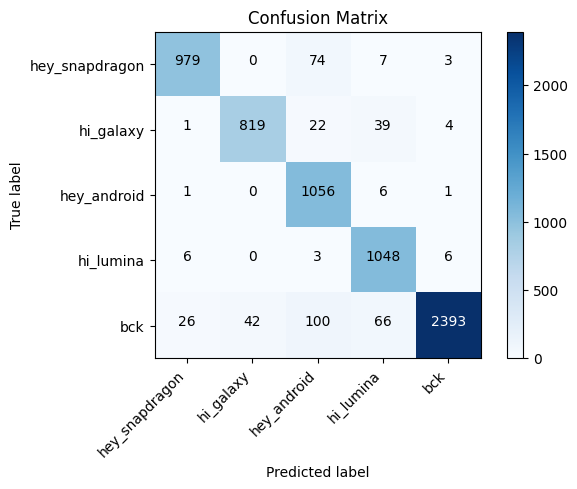

In [11]:
classes = set(np.squeeze(targets_set))
acc, conf_mat = calc_acc(classes, test_set, medoids, th=0.5, return_confmat=True)
print(acc)
keywords.append('bck')
plot_confusion_matrix(conf_mat,keywords)

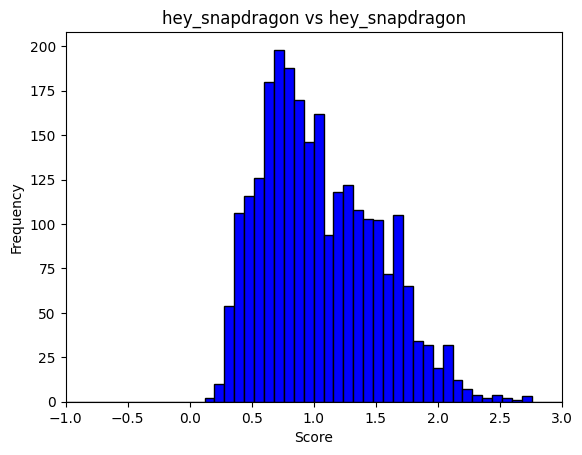

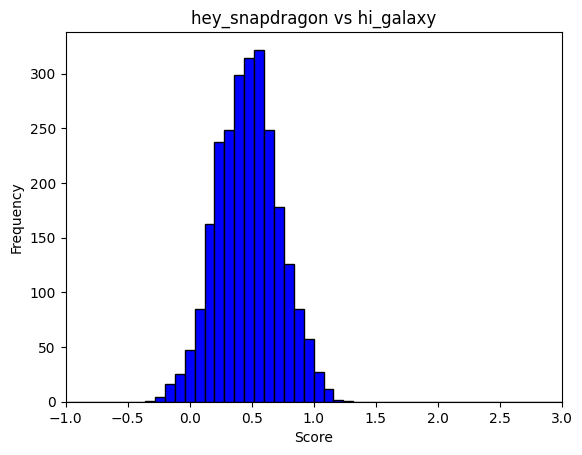

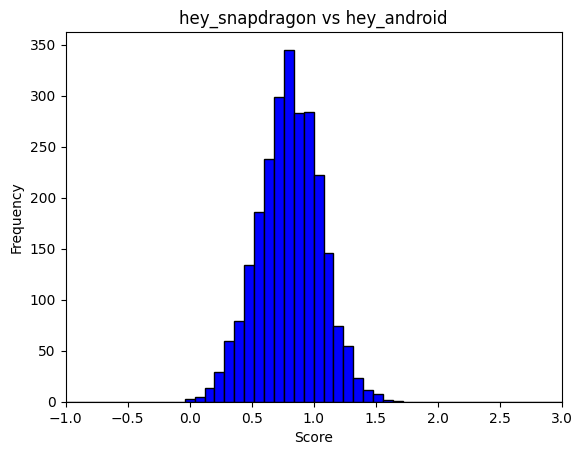

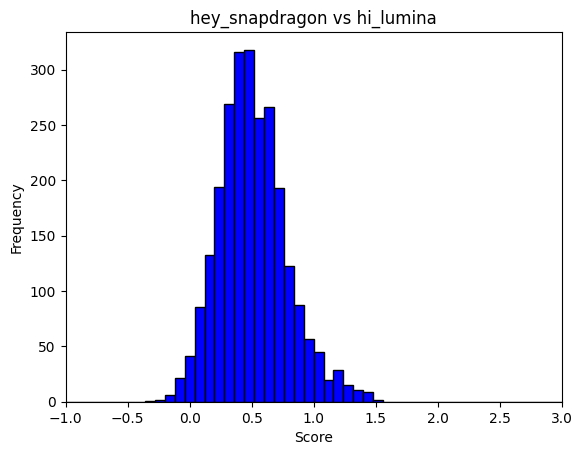

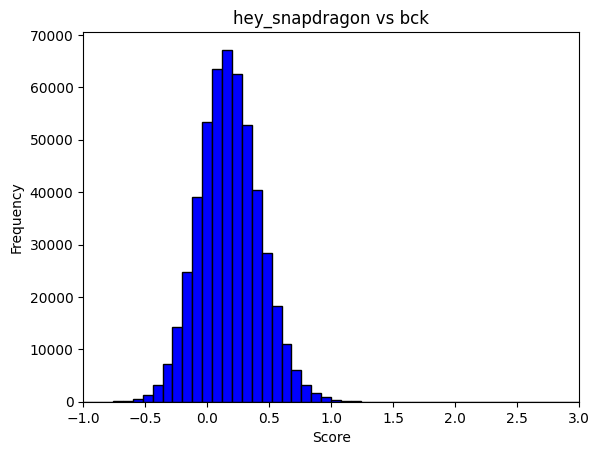

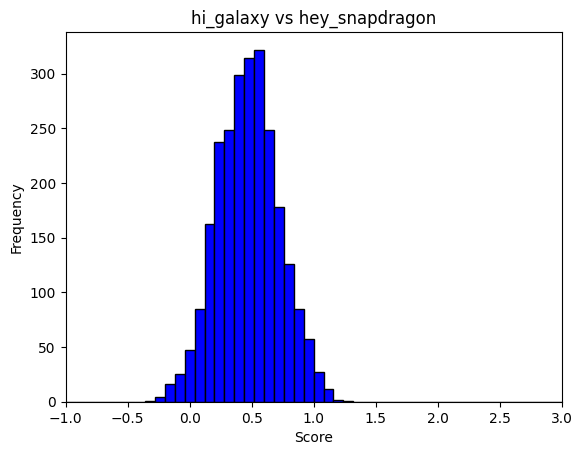

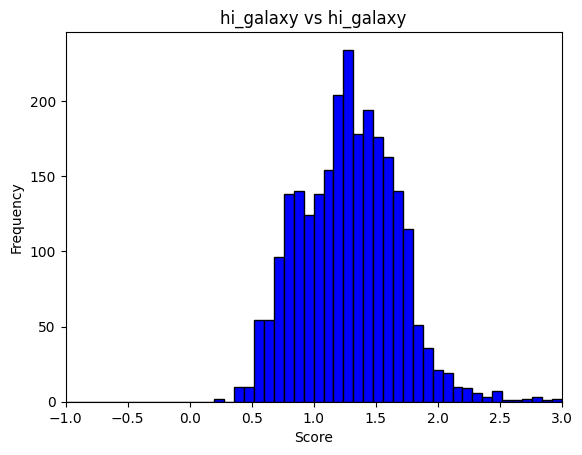

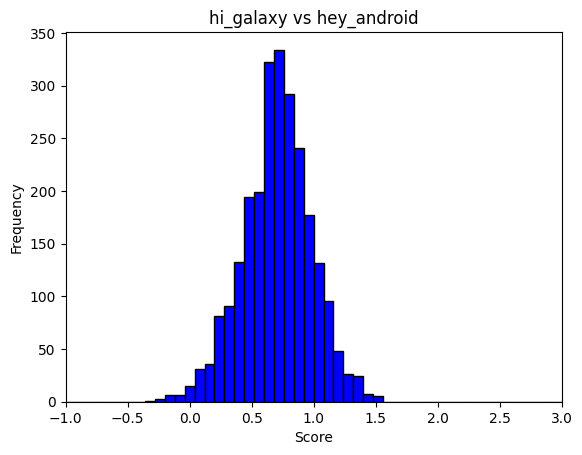

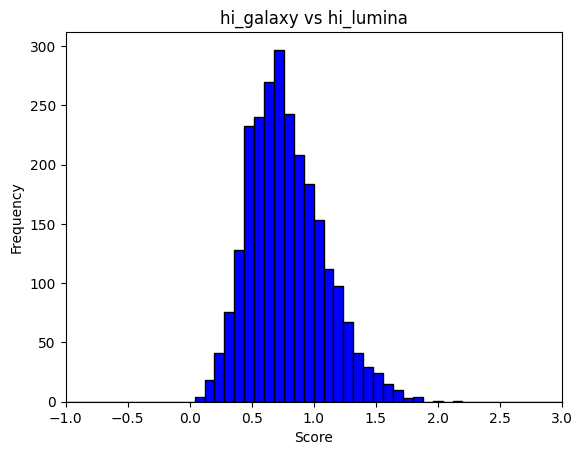

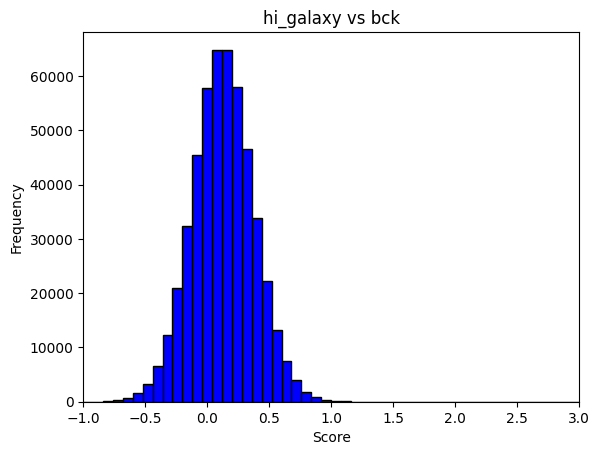

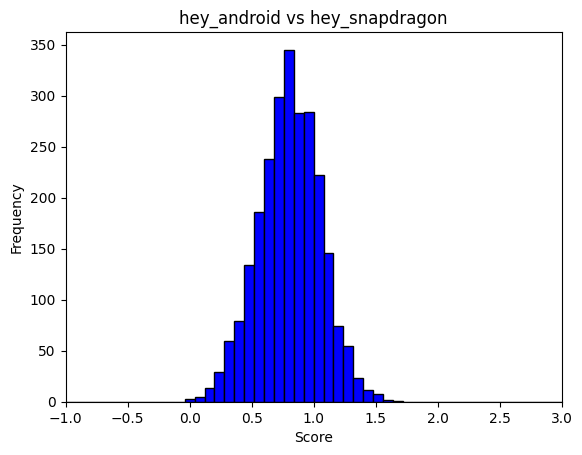

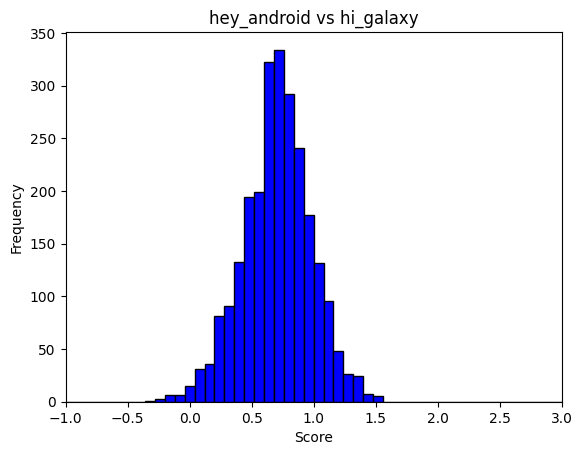

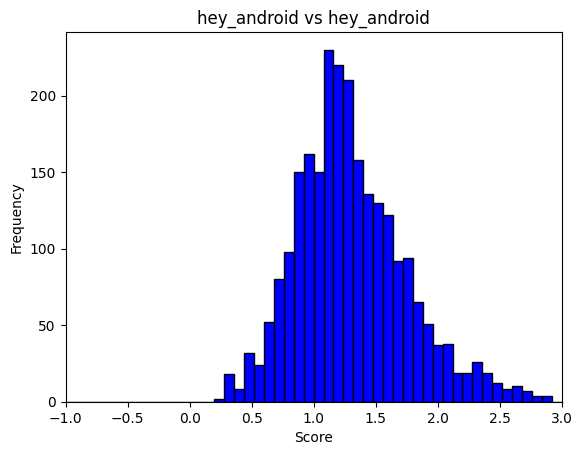

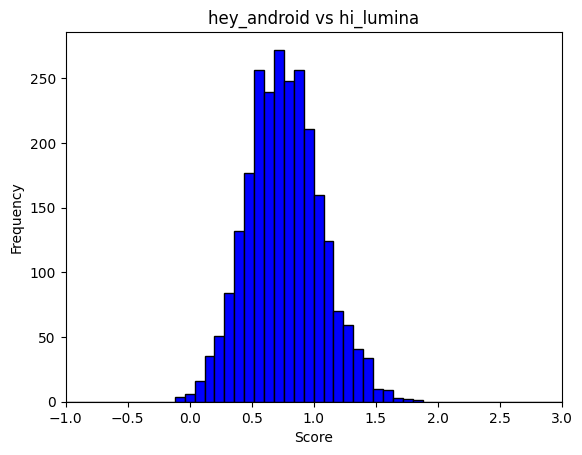

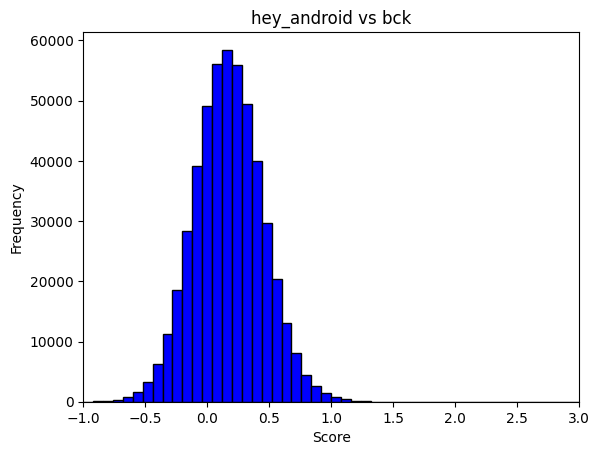

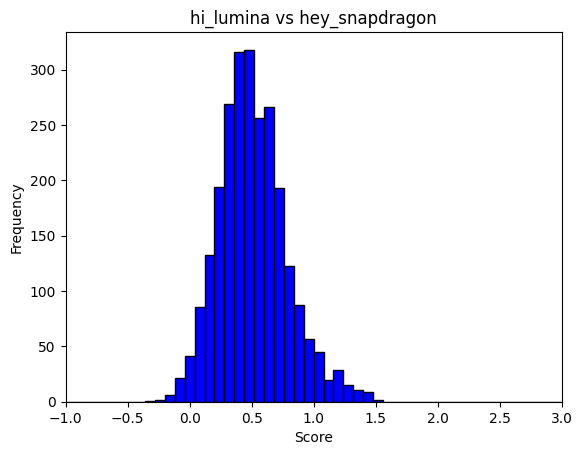

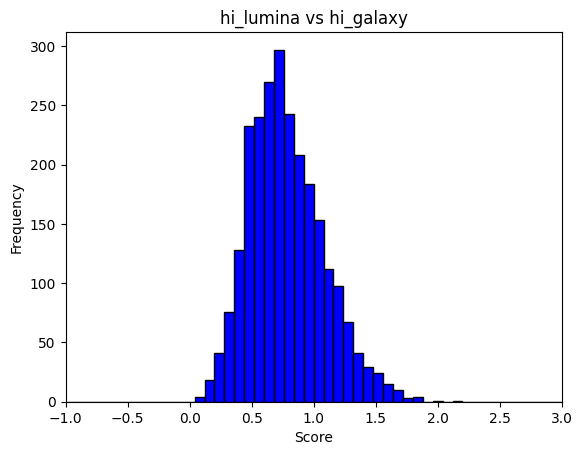

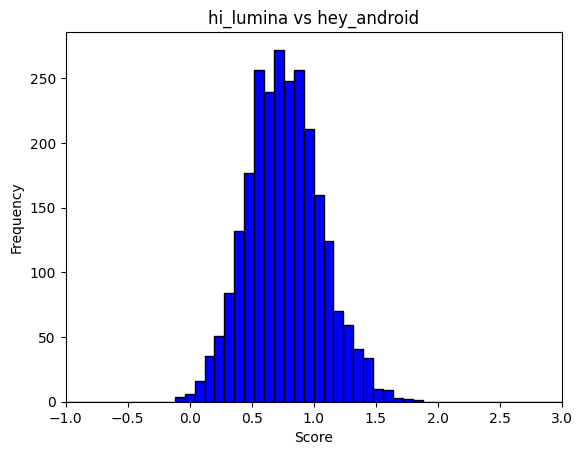

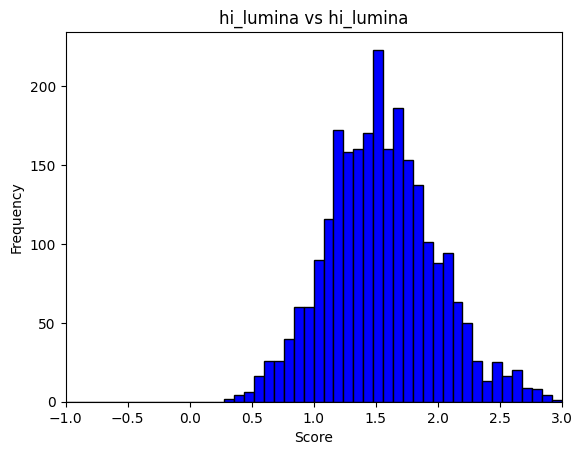

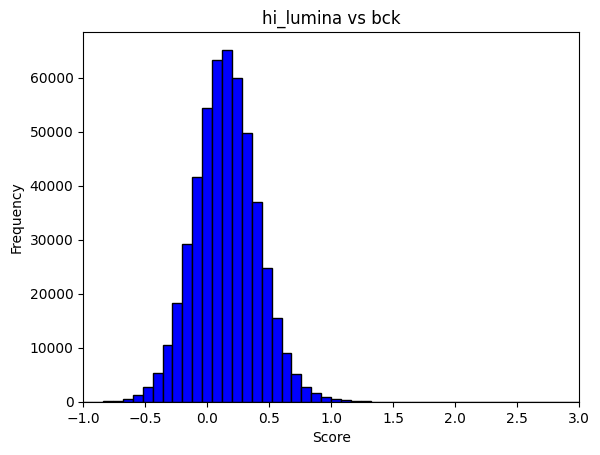

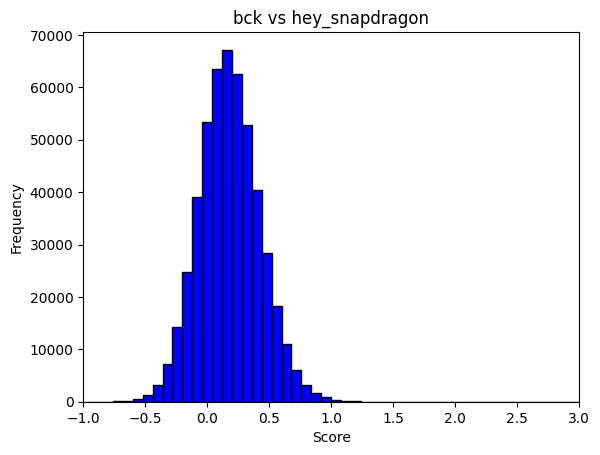

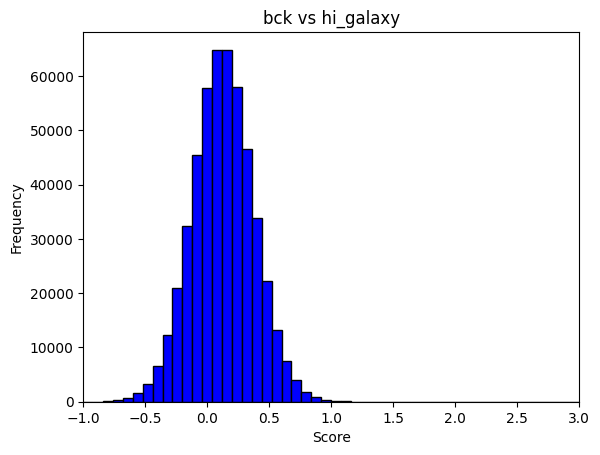

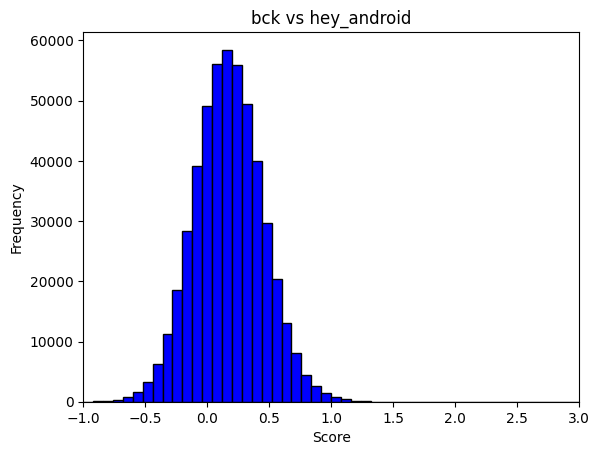

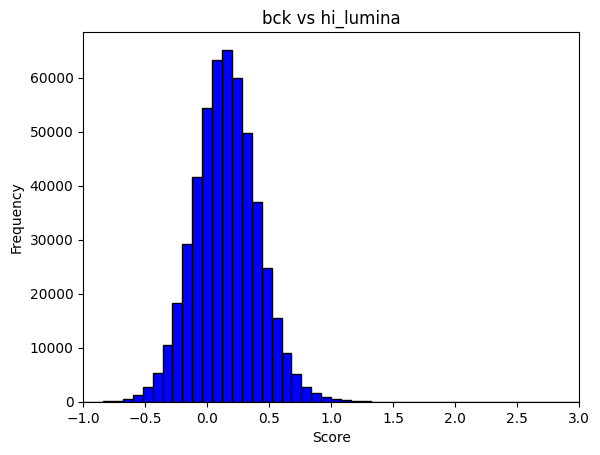

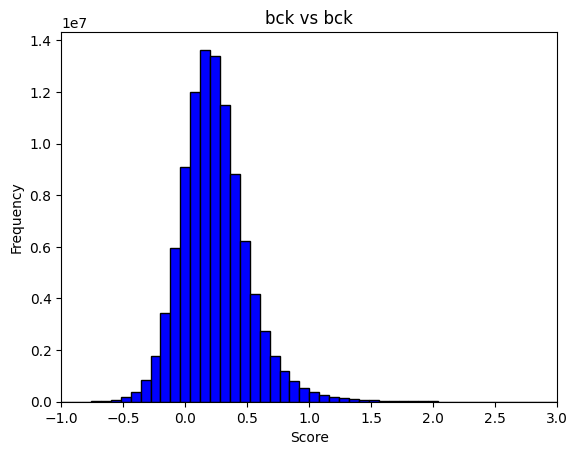

[[ 0.1416346  -0.31993231 -0.03377863 -0.28448918 -0.90694815]
 [-0.31993231  0.26965398 -0.28846565  0.08219574 -1.12321997]
 [-0.03377863 -0.28846565  0.21772192 -0.08684032 -1.08722425]
 [-0.28448918  0.08219574 -0.08684032  0.29628205 -1.09196734]
 [-0.90694815 -1.12321997 -1.08722425 -1.09196734 -1.66737986]]
[[3.3736639  1.28925371 1.69907856 1.52427983 1.48491657]
 [1.28925371 3.88589859 1.54225647 2.18563533 1.42075002]
 [1.69907856 1.54225647 3.45198774 1.87773502 2.05698586]
 [1.52427983 2.18563533 1.87773502 3.75069594 1.72489822]
 [1.48491657 1.42075002 2.05698586 1.72489822 6.47666264]]
[[1.05144644 0.47151649 0.80440158 0.50955629 0.17871752]
 [0.47151649 1.28376615 0.70474529 0.78217149 0.12585104]
 [0.80440158 0.70474529 1.31522596 0.76505566 0.17258517]
 [0.50955635 0.78217149 0.7650556  1.55674028 0.15160714]
 [0.17871749 0.12585102 0.17258516 0.15160717 0.23845591]]


In [12]:
mins = np.zeros((5,5))
maxes = np.zeros((5,5))
means = np.zeros((5,5))
for kw1 in range(0,5):
    for kw2 in range(0,5):
        keyword1, keyword2 = keywords[kw1],  keywords[kw2]
        medoid1, medoid2 = medoids[kw1], medoids[kw2]
        keyword_scores = np.matmul(medoid1, medoid2.T)
        mins[kw1, kw2] = keyword_scores.min()
        maxes[kw1, kw2] = keyword_scores.max()
        means[kw1, kw2] = keyword_scores.mean()
        plt.hist(keyword_scores.flatten(), bins=50, range=(-1, 3), color='blue', edgecolor='black')

        plt.title(f'{keyword1} vs {keyword2}')
        plt.xlabel('Score')
        plt.ylabel('Frequency')
        plt.xlim(-1, 3)
        plt.show()


print(mins)
print(maxes)
print(means)

# 9. write two get-batches: (1) inter-class separation (2) class vs background

In [ ]:
def get_batch_classes(data, targets, batch_size=32):

    K = len(set(np.squeeze(targets)))
    data_dim = data.shape[1]
    targets = np.asarray(targets)
    anchor = np.zeros((batch_size, data_dim))
    friend = np.zeros((batch_size, data_dim))
    foe = np.zeros((batch_size, data_dim))

    for k in range(batch_size):
        c1, c2 = random.sample(range(K-1), 2)
        friend_clas_indices = np.where(targets == c1)[0]
        foe_clas_indices = np.where(targets == c2)[0]

        anchor_inx, friend_inx = random.sample(list(friend_clas_indices), 2)
        foe_inx = random.sample(list(foe_clas_indices),1) [0]
        anchor[k, :] = data[anchor_inx]
        friend[k,  :] = data[friend_inx]
        foe[k, :] = data[foe_inx]

    friend_label = np.ones(batch_size)
    foe_label = np.zeros(batch_size)

    batch_1 = torch.from_numpy(np.concatenate((anchor, anchor), axis = 0)).to('cuda:0')
    batch_2 = torch.from_numpy(np.concatenate((friend, foe),  axis = 0)).to('cuda:0')
    label = torch.from_numpy(np.concatenate((friend_label, foe_label))).to('cuda:0')

    return batch_1.float(), batch_2.float(), label

def get_batch_bck(data, targets):
    data = training_set
    targets = training_labels
    K = len(set(np.squeeze(targets)))
    c2 = K-1    #为啥是K-1啊
    friend_inx = np.where(targets != c2)[0]
    foe_clas_indices = np.where(targets == c2)[0]
    foe_inx = random.sample(list(foe_clas_indices), len(friend_inx))
    data_dim = data.shape[1]
    targets = np.asarray(targets)
    anchor = np.zeros((len(friend_inx), data_dim))
    friend = np.zeros((len(friend_inx), data_dim))
    foe = np.zeros((len(friend_inx), data_dim))
    for k in range(len(friend_inx)):
        anchor[k,  :] = data[friend_inx[k]]
        foe[k, :] = data[foe_inx[k]]
    foe_label = np.zeros(len(friend_inx))
    batch_1 = torch.from_numpy(anchor).to('cuda:0')
    batch_2 = torch.from_numpy(foe).to('cuda:0')
    label = torch.from_numpy(foe_label).to('cuda:0')

    return batch_1.float(), batch_2.float(), label

跟5是一样的

In [ ]:
model.cuda()
medoids = []
data_shape = 128
test_set = np.empty((0, data_shape))
targets_set = np.empty((0,), dtype=int)
keywords = ['hey_snapdragon',
 'hi_galaxy',
 'hey_android',
 'hi_lumina']

for label, keyword in enumerate(keywords):
    keyword_waveform = test_features[keyword]['raw']
    emb_kwrd = model(torch.from_numpy(keyword_waveform).float().cuda().permute(0, 2, 1)).detach().cpu().numpy()
    train_test_split_address = f'/content/drive/MyDrive/Colab Notebooks/Capstone/最新代码/data/{keyword}_train_test_split.npz'
    data = np.load(train_test_split_address, allow_pickle=True)
    training_indexes = data.f.training_indexes
    test_indexes = data.f.test_indexes
    train_samples = emb_kwrd[training_indexes]
    test_samples = emb_kwrd[test_indexes]
    targets = label*np.ones((test_samples.shape[0],), dtype=int)
    test_set = np.concatenate((test_set, test_samples), axis=0)
    targets_set = np.concatenate((targets_set, targets), axis=0)
    medoids.append(train_samples)
background_waveform = test_features['background']['raw']
emb_bck = model(torch.from_numpy(background_waveform).float().cuda().permute(0, 2, 1)).detach().cpu().numpy()
train_samples = emb_bck[:10000]
test_samples = emb_bck[10000:]
targets = 4*np.ones((test_samples.shape[0],), dtype=int)
test_set = np.concatenate((test_set, test_samples), axis=0)
targets_set = np.concatenate((targets_set, targets), axis=0)
medoids.append(train_samples)

In [ ]:
training_set = np.vstack(medoids)
training_labels = np.hstack([[i]*medoids[i].shape[0] for i in range(5)]).flatten()

# 10. Train DML observe 3M (as well as class-bck distributions) every epoch determine threshold

0.5483437779767234
[[ 967   35   33   25    3]
 [  11  841    5   28    0]
 [  53   58  838  111    4]
 [   3   10   22 1026    2]
 [1782  321  204  317    3]]
0.7257535064159952
[[  15  138  154  167  589]
 [   0  861    2   16    6]
 [   0   74  889   79   22]
 [   0   12   23 1011   17]
 [   3  233  137  166 2088]]
0.7934944792599224
[[ 168   88   96   64  647]
 [   0  853    3   14   15]
 [   0   43  861   63   97]
 [   0    6   17  985   55]
 [   0   75   39   62 2451]]
0.7876753207997612
[[ 153   44   46   30  790]
 [   0  823    3   12   47]
 [   0   18  807   35  204]
 [   0    1   10  934  118]
 [   0   28   16   21 2562]]
0.7735004476275739
[[ 157   23   20   12  851]
 [   0  791    2   10   82]
 [   0    9  737   16  302]
 [   0    1    6  895  161]
 [   0   10    5    8 2604]]
0.7527603700387944
[[ 134    9   15    5  900]
 [   0  748    1    9  127]
 [   0    4  690    6  364]
 [   0    0    5  855  203]
 [   0    4    3    2 2618]]
0.7487317218740674
[[ 178    9   10    4

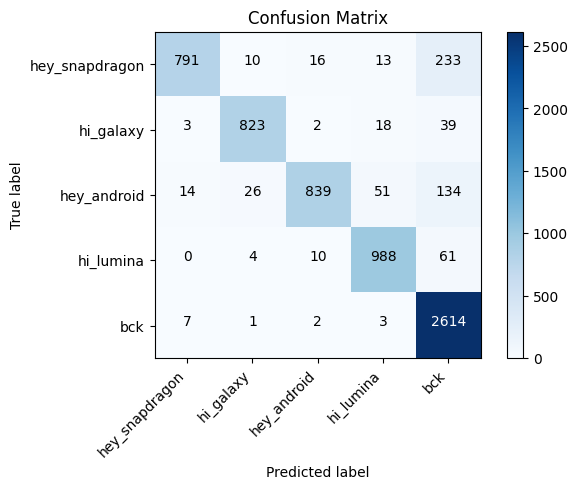

In [ ]:
device = 'cuda:0'
lr = 0.0003
margin = 0.9
batch_size = 128
model.to(device)
# sigma2 = DML2()
sigma2.float().to(device).train()
optimizer = torch.optim.Adam(sigma2.parameters(), lr=lr)
optimizer.zero_grad()
loss_fn = MaskedXentMarginLoss(margin=margin)
data_shape = 64
for i in range(10000):
    anchor, alien, labels = get_batch_bck(training_set, training_labels)
    optimizer.zero_grad()
    output = sigma2.forward(anchor, alien)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()
    if not i%2:
        anchor, alien, labels = get_batch_classes(training_set, training_labels, batch_size=batch_size)
        optimizer.zero_grad()
        output = sigma2.forward(anchor, alien)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
    if not i%200:    #到10000应该是差一个循环
        medoids = []
        test_set = np.empty((0, data_shape))
        targets_set = np.empty((0,), dtype=int)
        keywords = ['hey_snapdragon',
         'hi_galaxy',
         'hey_android',
         'hi_lumina']
        for label, keyword in enumerate(keywords):
            keyword_waveform = test_features[keyword]['raw']
            emb_kwrd = model(torch.from_numpy(keyword_waveform).float().to(device).permute(0, 2, 1))
            emb_kwrd = sigma2.forward_one(emb_kwrd).detach().cpu().numpy()
            train_test_split_address = f'/content/drive/MyDrive/Colab Notebooks/Capstone/最新代码/data/{keyword}_train_test_split.npz'
            data = np.load(train_test_split_address, allow_pickle=True)
            training_indexes = data.f.training_indexes
            test_indexes = data.f.test_indexes
            train_samples = emb_kwrd[training_indexes]
            test_samples = emb_kwrd[test_indexes]
            targets = label*np.ones((test_samples.shape[0],), dtype=int)
            test_set = np.concatenate((test_set, test_samples), axis=0)
            targets_set = np.concatenate((targets_set, targets), axis=0)
            medoids.append(train_samples)
        background_waveform = test_features['background']['raw']
        emb_bck = model(torch.from_numpy(background_waveform).float().to(device).permute(0, 2, 1))
        emb_bck = sigma2.forward_one(emb_bck).detach().cpu().numpy()
        train_samples = emb_bck[:10000]
        test_samples = emb_bck[10000:]
        targets = 4*np.ones((test_samples.shape[0],), dtype=int)
        test_set = np.concatenate((test_set, test_samples), axis=0)
        targets_set = np.concatenate((targets_set, targets), axis=0)
        medoids.append(train_samples)
        classes = set(np.squeeze(targets_set))
        acc, conf_mat = calc_acc(classes, test_set, medoids, th=3, return_confmat=True)
        print(acc)
        print(conf_mat)
keywords.append('bck')
plot_confusion_matrix(conf_mat,keywords)

0.9256938227394808
[[ 928   25   39   24   47]
 [   9  847    3   19    7]
 [  34   39  913   61   17]
 [   4   12   20 1017   10]
 [  51   20   16   41 2499]]
Confusion matrix, without normalization
[[ 928   25   39   24   47]
 [   9  847    3   19    7]
 [  34   39  913   61   17]
 [   4   12   20 1017   10]
 [  51   20   16   41 2499]]


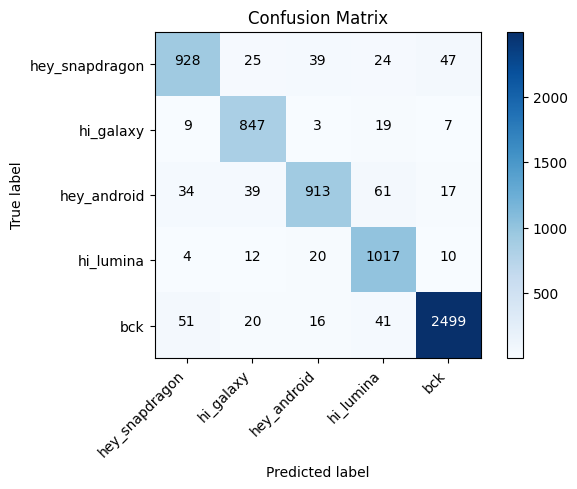

In [ ]:
medoids = []
test_set = np.empty((0, data_shape))
targets_set = np.empty((0,), dtype=int)
keywords = ['hey_snapdragon',
 'hi_galaxy',
 'hey_android',
 'hi_lumina']
for label, keyword in enumerate(keywords):
    keyword_waveform = test_features[keyword]['raw']
    emb_kwrd = model(torch.from_numpy(keyword_waveform).float().to(device).permute(0, 2, 1))
    emb_kwrd = sigma2.forward_one(emb_kwrd).detach().cpu().numpy()
    train_test_split_address = f'/content/drive/MyDrive/Colab Notebooks/Capstone/最新代码/data/{keyword}_train_test_split.npz'
    data = np.load(train_test_split_address, allow_pickle=True)
    training_indexes = data.f.training_indexes
    test_indexes = data.f.test_indexes
    train_samples = emb_kwrd[training_indexes]
    test_samples = emb_kwrd[test_indexes]
    targets = label*np.ones((test_samples.shape[0],), dtype=int)
    test_set = np.concatenate((test_set, test_samples), axis=0)
    targets_set = np.concatenate((targets_set, targets), axis=0)
    medoids.append(train_samples)
background_waveform = test_features['background']['raw']
emb_bck = model(torch.from_numpy(background_waveform).float().to(device).permute(0, 2, 1))
emb_bck = sigma2.forward_one(emb_bck).detach().cpu().numpy()
train_samples = emb_bck[:10000]
test_samples = emb_bck[10000:]
targets = 4*np.ones((test_samples.shape[0],), dtype=int)
test_set = np.concatenate((test_set, test_samples), axis=0)
targets_set = np.concatenate((targets_set, targets), axis=0)
medoids.append(train_samples)
classes = set(np.squeeze(targets_set))
acc, conf_mat = calc_acc(classes, test_set, medoids, th=-0.01, return_confmat=True)
print(acc)
print(conf_mat)
keywords.append('bck')
plot_confusion_matrix(conf_mat,keywords)

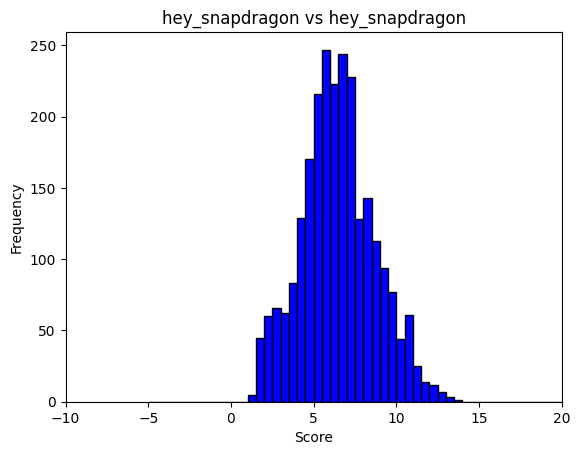

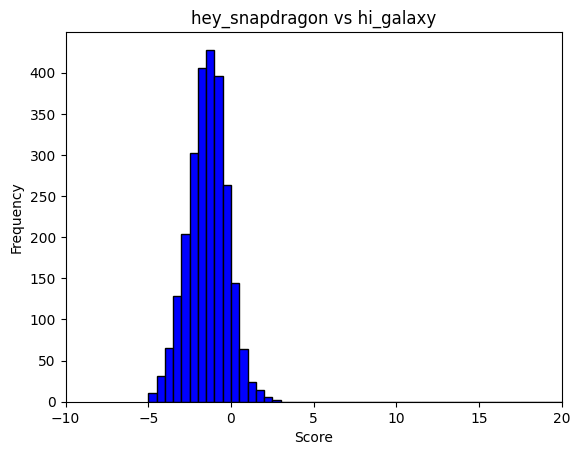

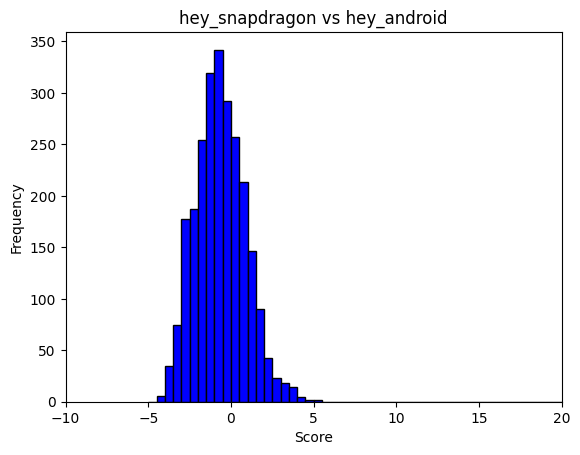

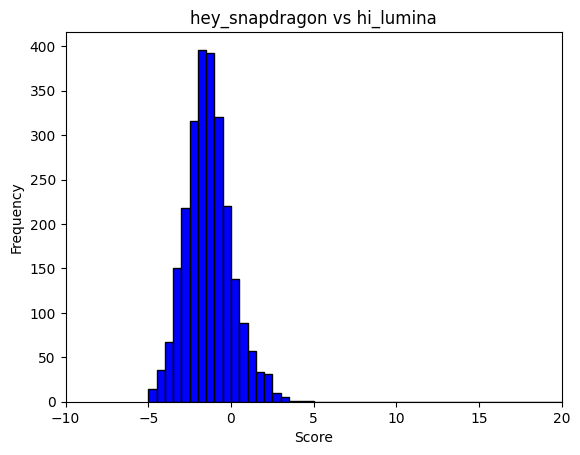

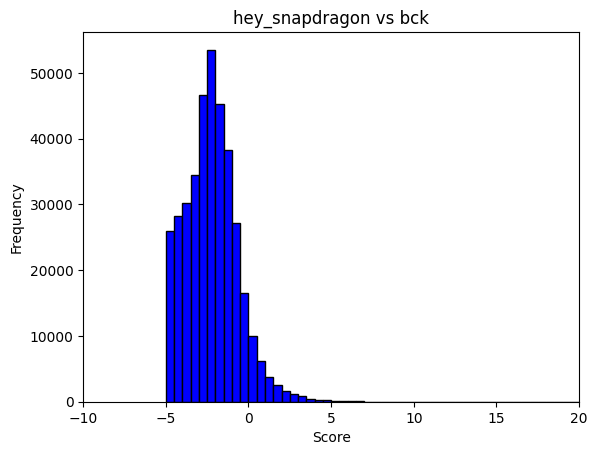

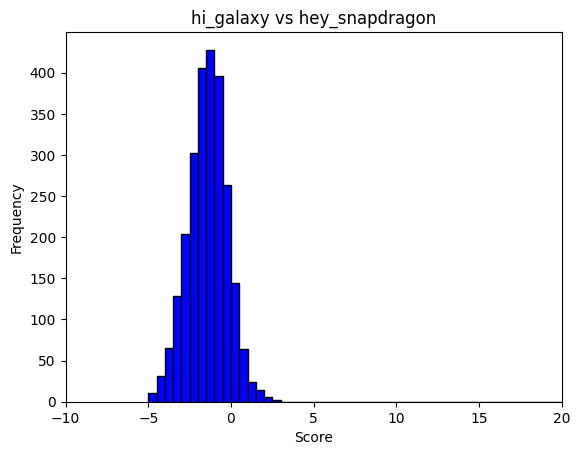

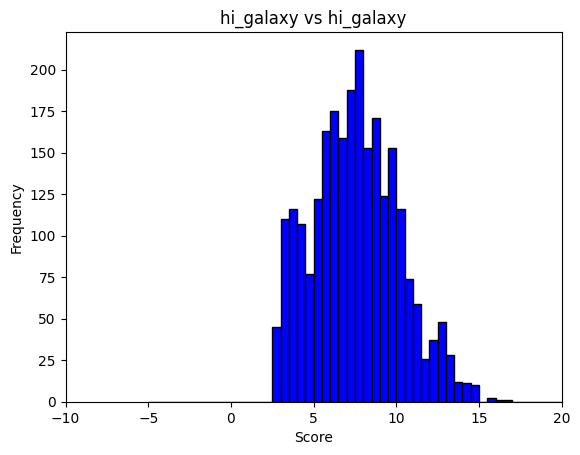

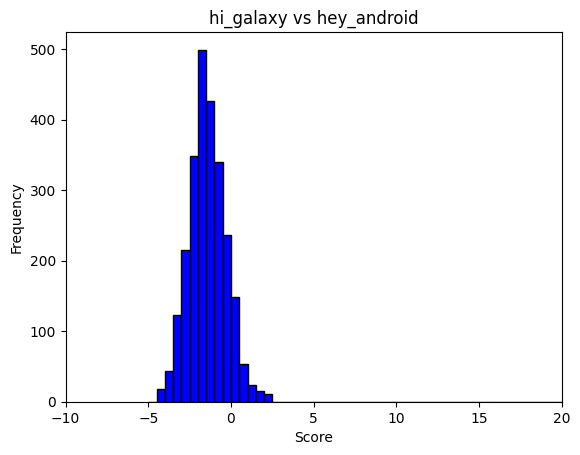

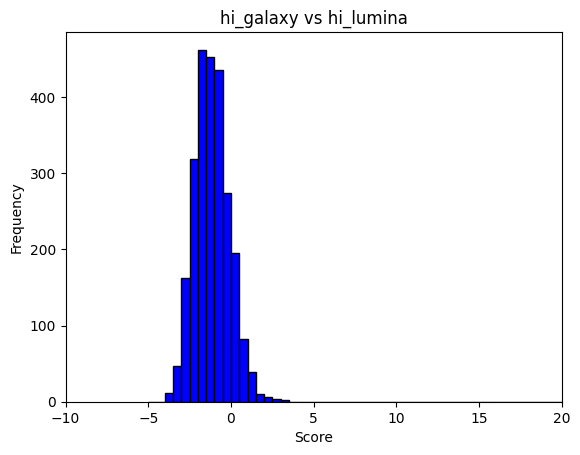

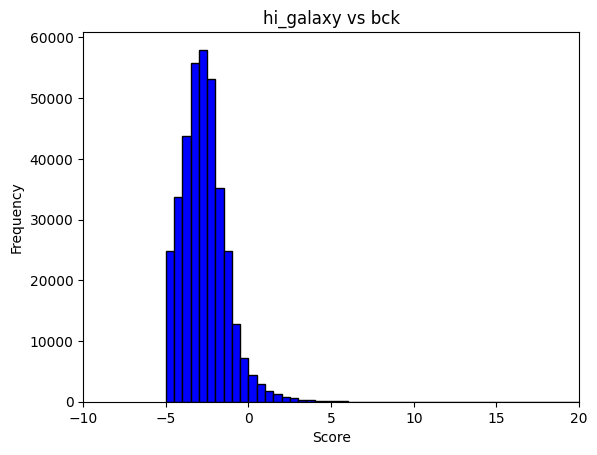

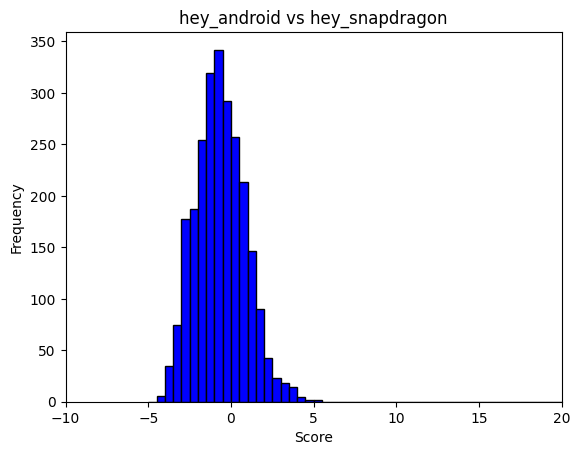

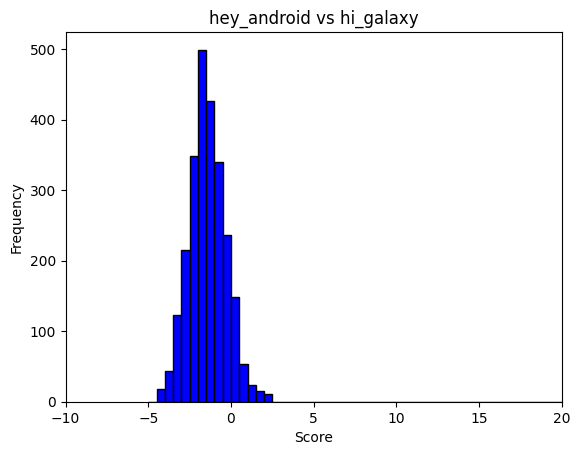

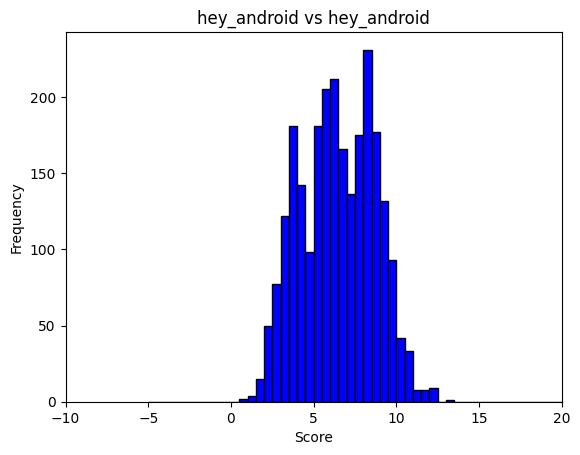

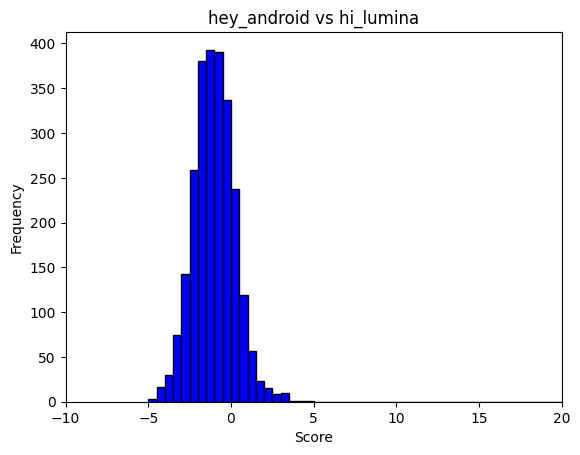

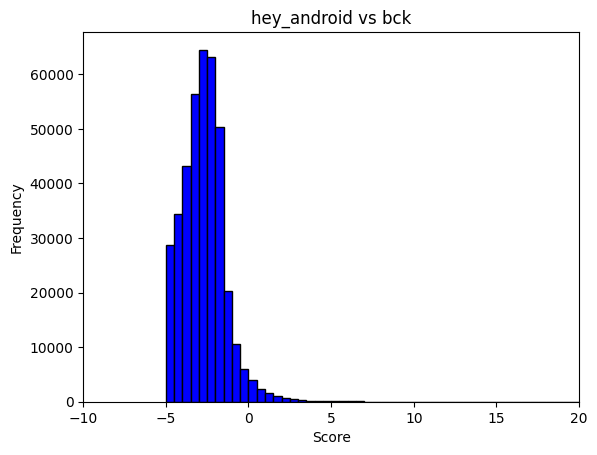

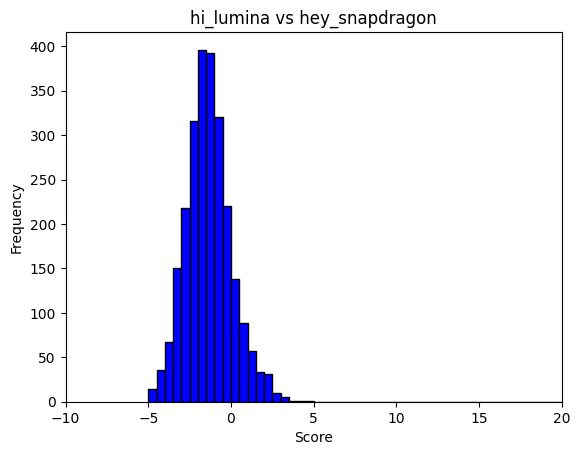

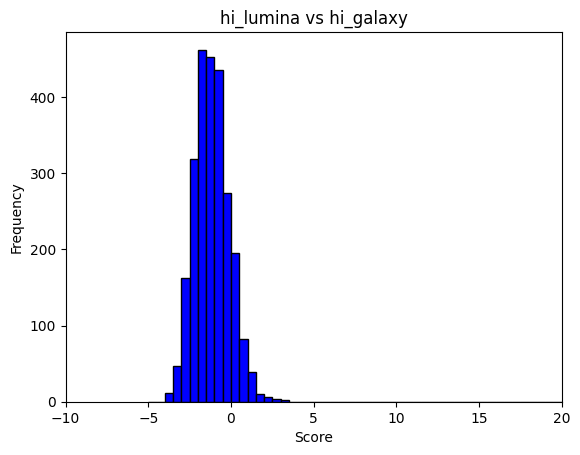

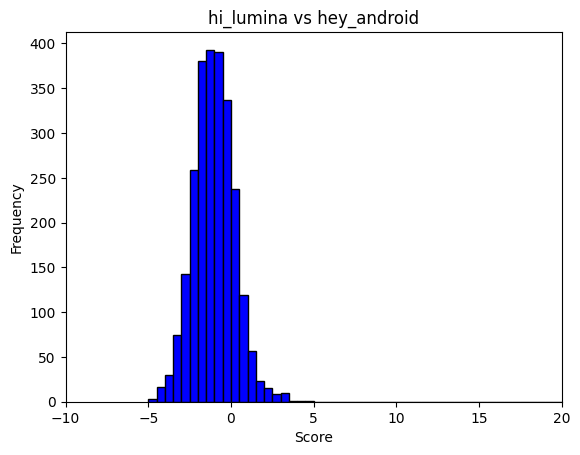

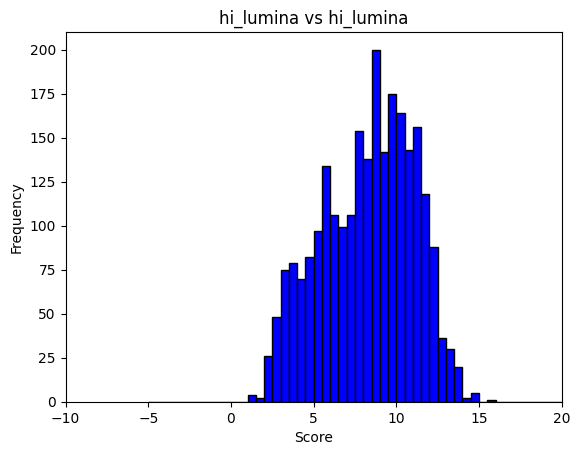

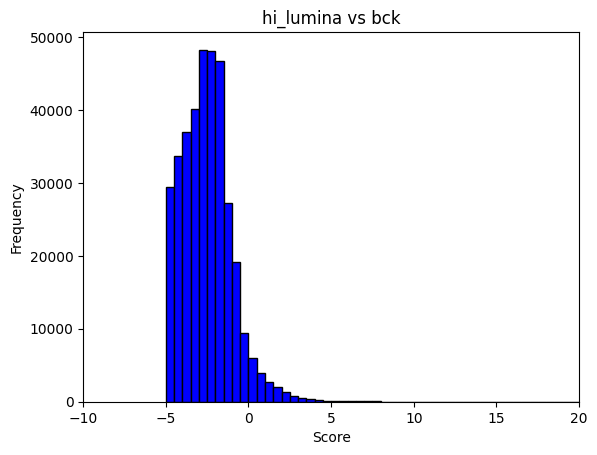

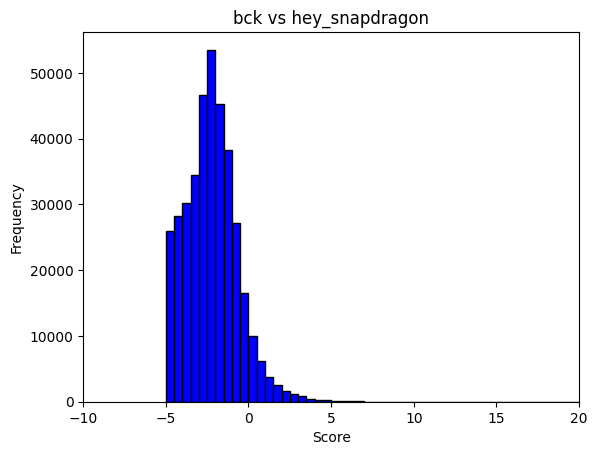

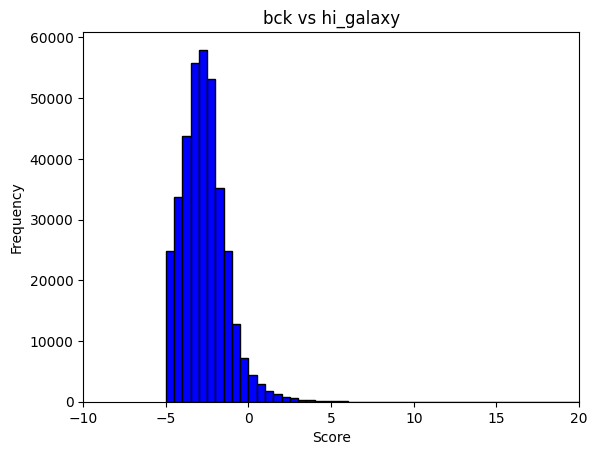

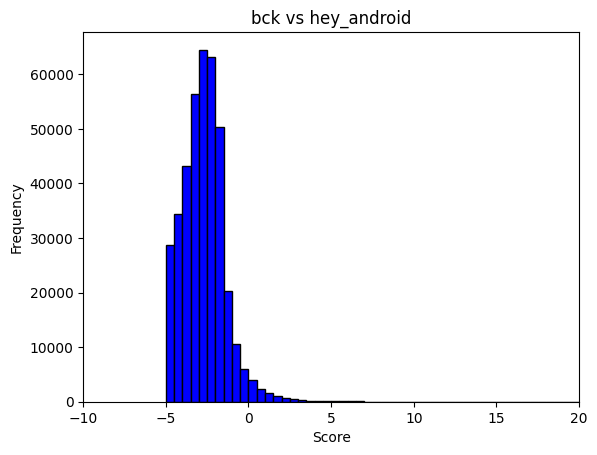

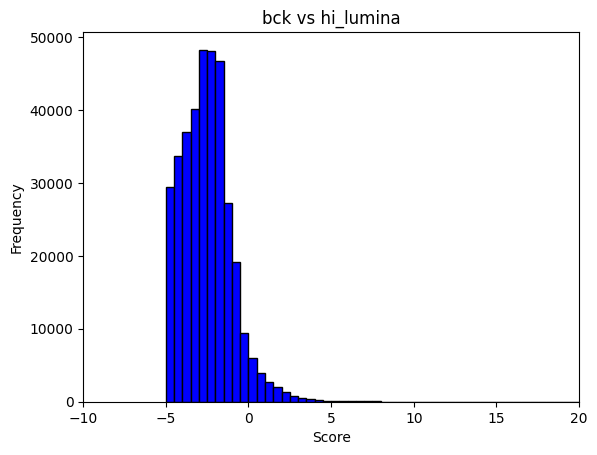

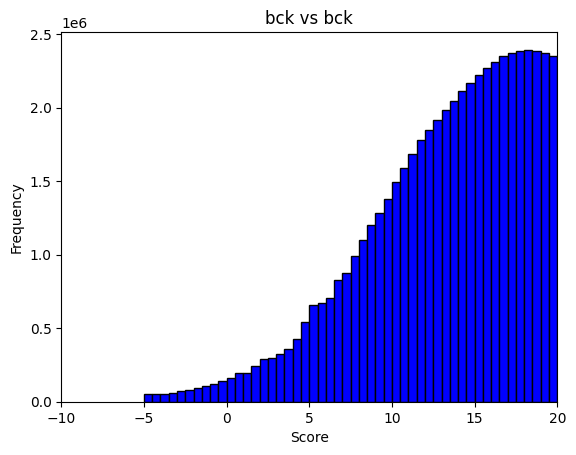

[[  1.00676239  -6.87280083  -4.48924255  -5.60363865 -20.44801521]
 [ -6.87280083   2.5563972   -4.43676329  -3.92348146 -13.52819347]
 [ -4.48924351  -4.43676329   0.97836041  -4.75835991 -14.64563942]
 [ -5.60363865  -3.92348146  -4.75835991   1.45380759 -15.16152763]
 [-20.44801521 -13.52819347 -14.64563942 -15.16152763 -18.71725845]]
[[13.84222412  2.64933562  5.43380737  4.61034584 11.62649441]
 [ 2.64933562 16.81452751  2.49391365  3.27273774  9.56730747]
 [ 5.43380737  2.49391484 13.00757408  4.5036478   8.78424072]
 [ 4.61034679  3.27273774  4.5036478  15.56441689  9.31610489]
 [11.62649441  9.56730747  8.78424072  9.31610489 56.4297905 ]]
[[ 6.45693922 -1.44056988 -0.64242131 -1.3659699  -3.63111138]
 [-1.44056976  7.52865696 -1.43025959 -1.16701794 -3.830441  ]
 [-0.64242125 -1.43025959  6.44355059 -1.03250825 -3.62160754]
 [-1.3659699  -1.16701794 -1.03250825  8.23026276 -3.86995625]
 [-3.63111138 -3.83044076 -3.6216073  -3.86995697 18.88368607]]


In [ ]:
mins = np.zeros((5,5))
maxes = np.zeros((5,5))
means = np.zeros((5,5))
keywords.append('bck')
for kw1 in range(0,5):
    for kw2 in range(0,5):
        keyword1, keyword2 = keywords[kw1],  keywords[kw2]
        medoid1, medoid2 = medoids[kw1], medoids[kw2]
        keyword_scores = np.matmul(medoid1, medoid2.T)
        mins[kw1, kw2] = keyword_scores.min()
        maxes[kw1, kw2] = keyword_scores.max()
        means[kw1, kw2] = keyword_scores.mean()
        plt.hist(keyword_scores.flatten(), bins=50, range=(-5, 20), color='blue', edgecolor='black')

        plt.title(f'{keyword1} vs {keyword2}')
        plt.xlabel('Score')
        plt.ylabel('Frequency')
        plt.xlim(-10, 20)
        plt.show()


print(mins)
print(maxes)
print(means)

In [ ]:
def first_nonzero(arr, axis=0, invalid_val=-1):
    mask = arr!=0
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

def detect_miss_rate_at_1FApH(false_rates, miss_rates, thresholds):
    index = 0
    while True:
        if false_rates[index]>10:
            return miss_rates[index-1], false_rates[index-1], thresholds[index-1]
        index += 1

def detect_fa_rate_at_90recall(false_rates, miss_rates, thresholds):
    index = -1
    while True:
        if miss_rates[index]>0.1:
            return miss_rates[index], false_rates[index], thresholds[index]
        index -= 1

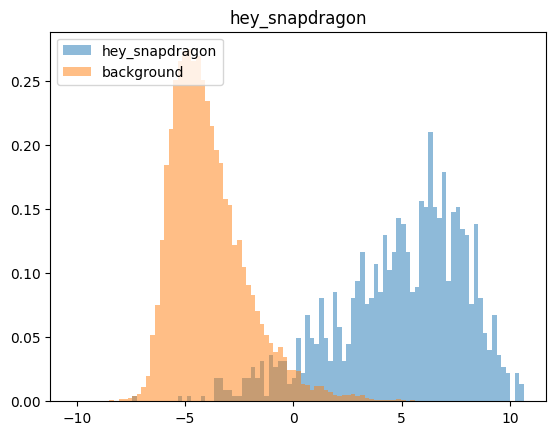

Calculating ROC


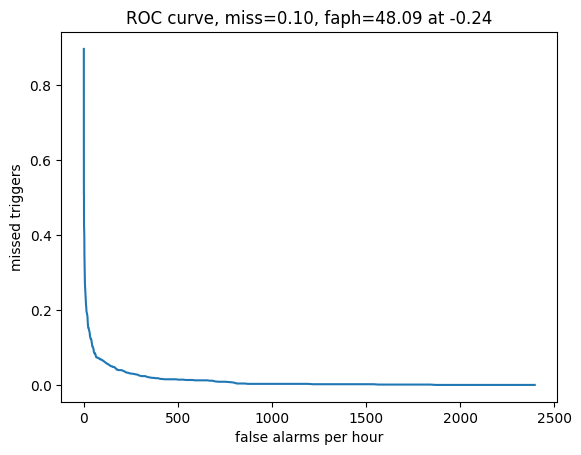

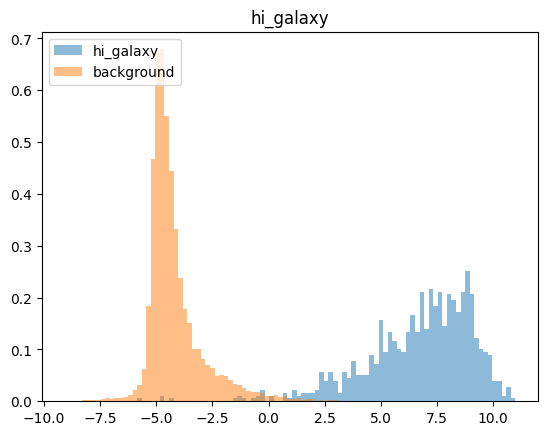

Calculating ROC


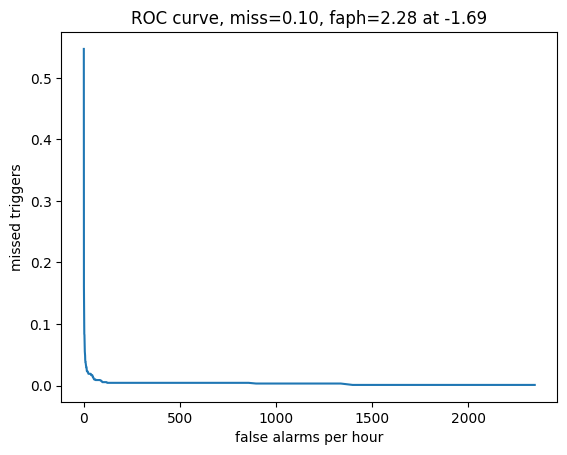

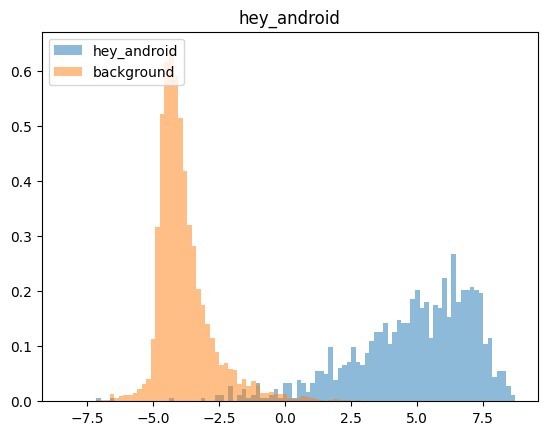

Calculating ROC


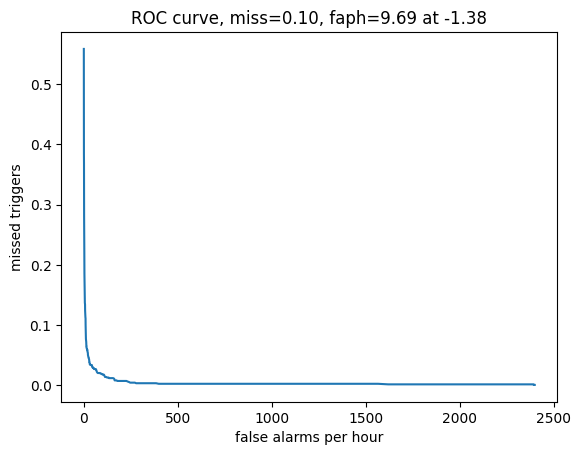

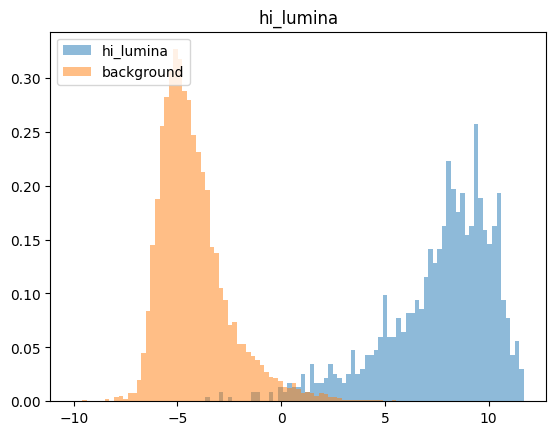

Calculating ROC


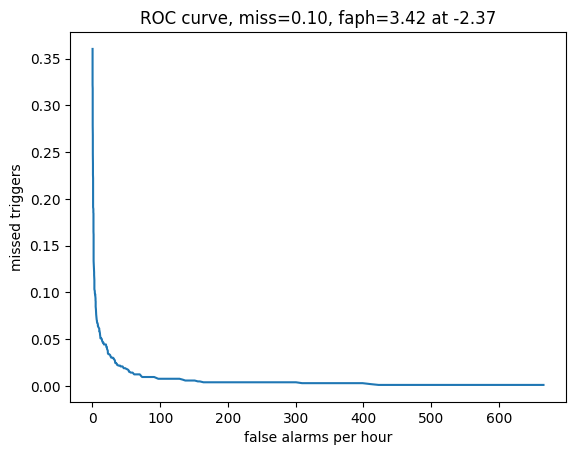

In [ ]:


keywords = ['hey_snapdragon',
 'hi_galaxy',
 'hey_android',
 'hi_lumina']
for keyword in keywords:
    keyword_waveform = test_features[keyword]['raw']
    emb_kwrd = model(torch.from_numpy(keyword_waveform).float().to(device).permute(0, 2, 1))
    emb_kwrd = sigma2.forward_one(emb_kwrd).detach().cpu().numpy()
    train_test_split_address = f'/content/drive/MyDrive/Colab Notebooks/Capstone/最新代码/data/{keyword}_train_test_split.npz'
    data = np.load(train_test_split_address, allow_pickle=True)
    training_indexes = data.f.training_indexes
    test_indexes = data.f.test_indexes
    train_samples = emb_kwrd[training_indexes]
    test_samples = emb_kwrd[test_indexes]

    background_waveform = test_features['background']['raw']
    emb_bck = model(torch.from_numpy(background_waveform).float().to(device).permute(0, 2, 1))
    emb_bck = sigma2.forward_one(emb_bck).detach().cpu().numpy()

    foes = np.zeros((emb_bck.shape[0],))
    keyword_scores = np.matmul(train_samples, test_samples.T)
    friends = np.mean(keyword_scores, axis=0)
    foes = np.mean(np.matmul(train_samples, emb_bck.T), axis=0)
    beg = min((min(friends), min(foes)))
    end = max((max(friends), max(foes)))
    bins = np.linspace(beg, end, 100)
    plt.hist(friends, bins, alpha=0.5, density=True,label=keyword)
    plt.legend(loc='upper left')
    plt.hist(foes, bins, alpha=0.5, density=True, label='background')
    plt.legend(loc='upper left')
    plt.title(f'{keyword}')
    plt.show()
    print('Calculating ROC')
    num_bins = 500
    roc_bins = np.linspace(beg, end, num_bins)
    miss_rate = np.zeros_like(roc_bins)
    false_rate = np.zeros_like(roc_bins)
    test_duration_in_hours = (foes.shape[0]*1.5)/(60*60)
    for i in range(num_bins):
        th = roc_bins[i]
        miss_rate[i] = sum(friends<th)/len(friends)
        false_rate[i] = sum(foes>th)/test_duration_in_hours

    false_rate_reversed = false_rate[::-1]
    miss_rate_reversed = miss_rate[::-1]
    inx = first_nonzero(false_rate_reversed)
    inx2 = num_bins - first_nonzero(miss_rate)
    miss, faph, th = detect_fa_rate_at_90recall(false_rate_reversed, miss_rate_reversed, roc_bins)
    plt.plot(false_rate_reversed[inx:inx2], miss_rate_reversed[inx:inx2])
    plt.title(f'ROC curve, miss={miss:.2f}, faph={faph:.2f} at {th:.2f}')
    plt.xlabel("false alarms per hour")
    plt.ylabel("missed triggers")
    plt.show()